In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/KiPA2022

/content/drive/MyDrive/KiPA2022


In [ ]:
#!unzip /content/drive/MyDrive/KiPA2022/train_my.zip

In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 721 kB 35.7 MB/s 


In [ ]:
import os
from glob import glob
import shutil
from tqdm import tqdm
#import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

In [ ]:
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
import torch
inp=torch.rand(1,1,128,128,128)
inp1=torch.rand(1,4,128,128,128)
pred=torch.rand(1,4,128,128,128)
los=loss_function(pred,inp)
print(los)

m=dice_metric(pred,inp1)
print(m)


tensor(2.3171)
tensor([[0.4999, 0.5001, 0.4998, 0.5002]])


/usr/local/lib/python3.7/dist-packages/monai/metrics/meandice.py:73: UserWarning: y_pred should be a binarized tensor.
  warnings.warn("y_pred should be a binarized tensor.")
/usr/local/lib/python3.7/dist-packages/monai/metrics/meandice.py:75: UserWarning: y should be a binarized tensor.
  warnings.warn("y should be a binarized tensor.")


In [ ]:
from monai.transforms import (AsDiscrete)
post_label = AsDiscrete(to_onehot=4)
pred=torch.rand(1,4,128,128,128)
out=post_label(inp)
out1=post_label(pred)
#print(out1.shape)
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
val_labels_list = decollate_batch(inp)
val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]

#val_labels_convert

ModuleNotFoundError: ignored

In [ ]:
val_outputs_list = decollate_batch(pred)
post_pred = AsDiscrete(argmax=True, to_onehot=4)
val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
dice_metric(y_pred=val_output_convert, y=val_labels_convert)

tensor([[0.4004,    nan,    nan,    nan]])

In [ ]:
mean_dice_val = dice_metric.aggregate().item()

In [ ]:
mean_dice_val

0.4335677921772003

In [ ]:
#https://github.com/amine0110/Liver-Segmentation-Using-Monai-and-PyTorch
def find_empy(in_dir):
    '''
    This function will help you to find the empty volumes that you may not need for your training
    so instead of opening all the files and search for the empty ones, them use this function to make it quick.
    '''
    
    list_patients = []
    for patient in glob(os.path.join(in_dir, '*')):
        img = nib.load(patient)

        if len(np.unique(img.get_fdata())) > 2:
            print(os.path.basename(os.path.normpath(patient)))
            list_patients.append(os.path.basename(os.path.normpath(patient)))
    
    return list_patients

In [ ]:
import os
from glob import glob
import shutil
from tqdm import tqdm
#import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
set_determinism(seed=0)
import os
import nibabel as nib
import glob
#import SimpleITK as sitk
in_dir='/content/drive/MyDrive/KiPA2022/train_my/train'
#pathim=os.path.join(in_dir,'image')
#pathlabel=os.path.join(in_dir,'label')
path_train_volumes = sorted(glob.glob(os.path.join(in_dir, "image", "*.nii.gz")))
path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "label", "*.nii.gz")))


In [ ]:
pathtrainlst=[]
for i in range(0,len(path_train_volumes)):
  pathtrain=path_train_volumes[i][41:]
  pathtrainlst.append(pathtrain)
  #print(pathtrain)
  break

In [ ]:
#pathtrainlst

In [ ]:
cd /content/drive/MyDrive/KiPA2022

/content/drive/MyDrive/KiPA2022


In [ ]:
#import os 
#root='C:\\Users\\Administrateur\\Desktop\\micca2021\\MICCAI2021\\FetaEndo_challenege\\FetReg2021_Task1_Segmentation'
#lstdir=os.listdir(root)

import random
#random.seed(0)
def Trian_val(data_list,test_size=0.15):
    n=len(data_list)
    m=int(n*test_size)
    test_item=random.sample(data_list,m)
    train_item=list(set(data_list)-set(test_item))
    return train_item,test_item
tr_list,test_list=Trian_val(pathtrainlst,test_size=0.20)
import pandas as pd
df_test= pd.DataFrame(test_list,columns=['PatientID'])
df_train= pd.DataFrame(tr_list,columns=['PatientID'])
# df.to_csv("testing_list1.csv",index=False)
# df1e=df11.drop(['index'],axis=0)
# df11.values()
df_test.to_csv('valid_fold0.csv', index=False) 
df_train.to_csv('train_fold0.csv', index=False)        

In [ ]:
#df_train

In [ ]:
import pandas as pd
train_file=pd.read_csv('/content/drive/MyDrive/KiPA2022/train_fold0.csv')
in_dir='/content/drive/MyDrive/KiPA2022/train_my/'
path_train_volumes=[]
path_train_segmentation=[]
for i in range(0,len(train_file)):
  pathtrain=train_file['PatientID'][i]
  path_train_volumes.append(os.path.join(in_dir,pathtrain))
  pathtrain.replace('image','label')
  path_train_segmentation.append(os.path.join(in_dir,pathtrain.replace('image','label')))

  #print(pathtrain)

In [ ]:
path_train_segmentation

['/content/drive/MyDrive/KiPA2022/train_my/train/label/22.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/64.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/3.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/25.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/56.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/29.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/65.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/40.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/69.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/13.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/44.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/63.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/23.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/14.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/9.nii.gz

In [ ]:
import pandas as pd
in_dir='/content/drive/MyDrive/KiPA2022/train_my/'
train_file=pd.read_csv('/content/drive/MyDrive/KiPA2022/valid_fold0.csv')
path_valid_volumes=[]
path_valid_segmentation=[]
for i in range(0,len(train_file)):
  pathtrain=train_file['PatientID'][i]
  pathf=os.path.join(in_dir,pathtrain)
  path_valid_volumes.append(pathf)
  pathtrain.replace('image','label')
  path_valid_segmentation.append(os.path.join(in_dir,pathtrain.replace('image','label')))

In [ ]:
path_valid_segmentation

['/content/drive/MyDrive/KiPA2022/train_my/train/label/33.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/67.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/24.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/41.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/7.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/2.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/38.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/61.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/4.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/5.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/55.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/43.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/60.nii.gz',
 '/content/drive/MyDrive/KiPA2022/train_my/train/label/17.nii.gz']

In [ ]:
pathf=os.path.join(in_dir,pathtrain)
print(pathf)

/content/drive/MyDrive/KiPA2022/train_my/train/train/image/17.nii.gz


In [ ]:
train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]

In [ ]:
#train_files

In [ ]:
valid_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(path_valid_volumes, path_valid_segmentation)]

In [ ]:
#path_train_volumes
###### create nnunet monaie for multiclass 3D segmentation problem
import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    Spacingd,
    Orientationd,
    SpatialPadd,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    CastToTyped,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandFlipd,
    ToTensord,
    Resized,RandShiftIntensityd,SpatialPadd
)
from monai.utils import first
#image_keys: ["image"]
#all_keys: ["image", "label"]

generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(0.632813, 0.632813, 0.632813), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #CropForegroundd(keys=['image','label'], source_key='image'),
        SpatialPadd(keys=["image", "label"], spatial_size=[128,128,128]),
        #Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        ScaleIntensityRanged(keys=["image"], a_min=918.0, a_max=1396.0,b_min=0.0, b_max=1.0, clip=True,),
        RandCropByPosNegLabeld(  # crop with center in label>0 with proba pos / (neg + pos)
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,128),
            pos=1,
            neg=0,  # never center in background voxels
            num_samples=4,
            image_key='image',  # for no restriction with image thresholding
            image_threshold=0,
        ), 
        RandGaussianNoised(keys="image", mean=0., std=0.1, prob=0.2),
        RandGaussianSmoothd(
            keys=["image"],
            sigma_x=(0.5, 1.15),
            sigma_y=(0.5, 1.15),
            sigma_z=(0.5, 1.15),
            prob=0.2,
          ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
            ),
        RandAdjustContrastd(  # same as Gamma in nnU-Net
            keys=["image"],
            gamma=(0.7, 1.5),
            prob=0.3,
          ),
        RandZoomd(
            keys=["image", "label"],
            min_zoom=0.7,
            max_zoom=1.5,
            mode=("trilinear",) * len(["image"]) + ("nearest",),
            align_corners=(True,) * len(["image"]) + (None,),
            prob=0.3,
          ),
          #RandRotated(
          #  keys=["image", "label"],
          #  range_x=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
           # range_y=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
           # range_z=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
           # mode=("bilinear",) * len(["image"]) + ("nearest",),
           # align_corners=(True,) * len(["image"]) + (None,),
            #padding_mode=("border", ) * len(["image", "label"]),
            #prob=0.3,
           # ),
        CastToTyped(keys=["image", "label"], dtype=(np.float32,) * len(["image"]) + (np.uint8,)),
        #RandFlipd(keys=["image"], spatial_axis=[0, 1, 2], prob=0.5),
        #RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        #RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        #RandGaussianNoised(keys='image', prob=0.5),
        #NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

my_transform_org=Compose([LoadImaged(keys=["image", "label"]),AddChanneld(keys=["image", "label"]),
                          ToTensord(keys=["image", "label"])])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.632813, 0.632813, 0.632813),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=918.0, a_max=1396.0, b_min=0.0, b_max=1.0, clip=True
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

original_ds = Dataset(data=train_files, transform=my_transform_org)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

In [ ]:
my_transform_org=Compose([LoadImaged(keys=["image", "label"]),AddChanneld(keys=["image", "label"]),ToTensord(keys=["image", "label"])])
generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1, shuffle=True, pin_memory=True)

#generat_loader = DataLoader(generat_ds, batch_size=4)
for i,d in enumerate(generat_loader):
  print(d['image'].shape)
  print(d['label'].shape)
  #break

torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4, 1, 128, 128, 128])
torch.Size([4,

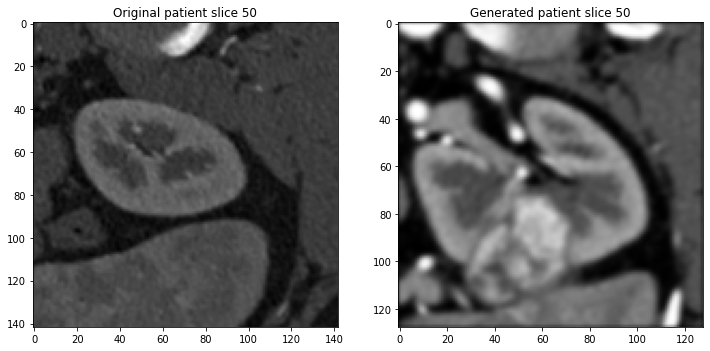

In [ ]:
import matplotlib.pyplot as plt
number_slice = 50
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")

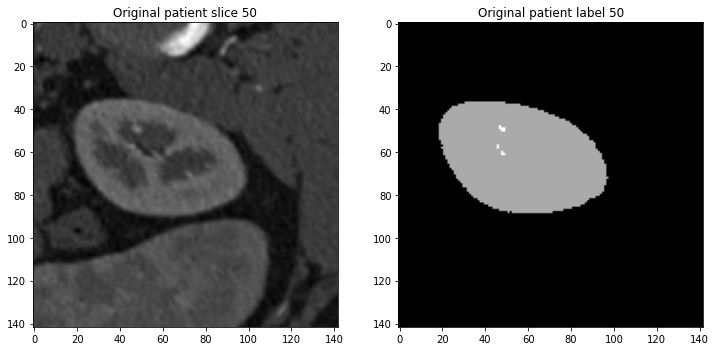

In [ ]:
import matplotlib.pyplot as plt
number_slice = 50
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Original patient label {number_slice}")
plt.imshow(original_patient["label"][0, 0, :, :, number_slice], cmap="gray")

In [ ]:
np.unique(generat_patient["label"].numpy())

array([0, 1, 2, 3, 4], dtype=uint8)

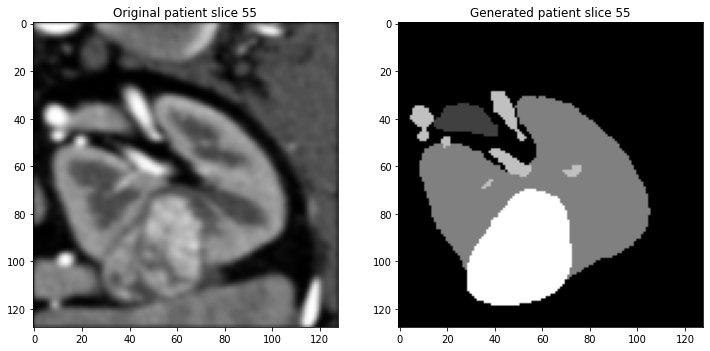

In [ ]:
import matplotlib.pyplot as plt
number_slice = 55
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["label"][0, 0, :, :, number_slice], cmap="gray")

In [ ]:
##### valid dataset
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.632813, 0.632813, 0.632813),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=918.0, a_max=1396.0, b_min=0.0, b_max=1.0, clip=True
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
generat_ds = Dataset(data=valid_files, transform=val_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

original_ds = Dataset(data=valid_files, transform=my_transform_org)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

In [ ]:
#my_transform_org=Compose([LoadImaged(keys=["image", "label"]),AddChanneld(keys=["image", "label"]),ToTensord(keys=["image", "label"])])
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        #Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.632813, 0.632813, 0.632813),
            mode=("bilinear", "nearest"),
        ),
        #Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        ScaleIntensityRanged(
            keys=["image"], a_min=918.0, a_max=1396.0, b_min=0.0, b_max=1.0, clip=True
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
valid_ds = Dataset(data=valid_files, transform=val_transforms)
generat_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
#generat_loader = DataLoader(generat_ds, batch_size=4)
for i,d in enumerate(generat_loader):
  print(d['image'].shape)
  print(d['label'].shape)
  #break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 1, 171, 171, 187])
torch.Size([1, 1, 171, 171, 187])
torch.Size([1, 1, 145, 145, 203])
torch.Size([1, 1, 145, 145, 203])
torch.Size([1, 1, 134, 134, 207])
torch.Size([1, 1, 134, 134, 207])
torch.Size([1, 1, 150, 150, 177])
torch.Size([1, 1, 150, 150, 177])
torch.Size([1, 1, 157, 157, 204])
torch.Size([1, 1, 157, 157, 204])
torch.Size([1, 1, 143, 143, 191])
torch.Size([1, 1, 143, 143, 191])
torch.Size([1, 1, 136, 136, 216])
torch.Size([1, 1, 136, 136, 216])
torch.Size([1, 1, 144, 144, 169])
torch.Size([1, 1, 144, 144, 169])
torch.Size([1, 1, 162, 162, 185])
torch.Size([1, 1, 162, 162, 185])
torch.Size([1, 1, 141, 141, 180])
torch.Size([1, 1, 141, 141, 180])
torch.Size([1, 1, 144, 144, 210])
torch.Size([1, 1, 144, 144, 210])
torch.Size([1, 1, 151, 151, 188])
torch.Size([1, 1, 151, 151, 188])
torch.Size([1, 1, 137, 137, 214])
torch.Size([1, 1, 137, 137, 214])
torch.Size([1, 1, 150, 150, 196])
torch.Size([1, 1, 150, 150, 196])


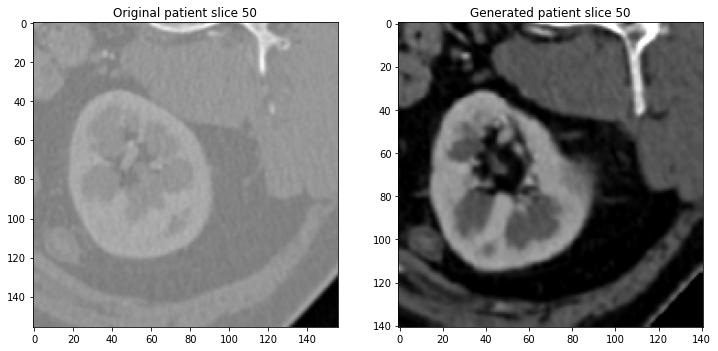

In [ ]:
import matplotlib.pyplot as plt
number_slice = 50
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")

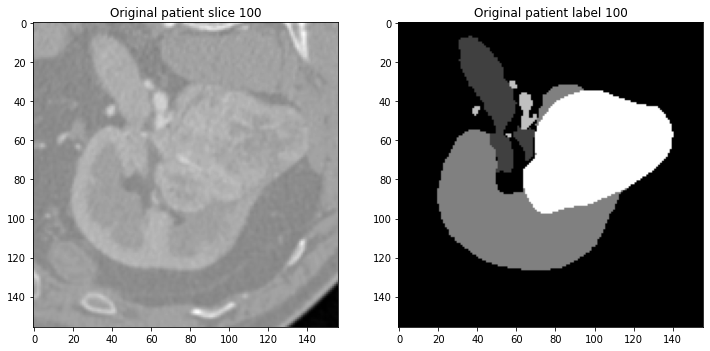

In [ ]:
import matplotlib.pyplot as plt
number_slice = 100
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Original patient label {number_slice}")
plt.imshow(original_patient["label"][0, 0, :, :, number_slice], cmap="gray")

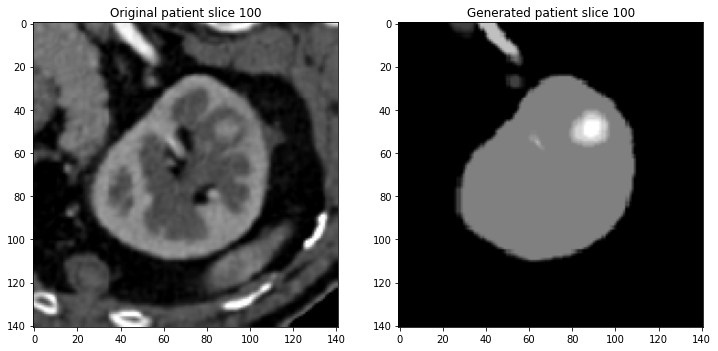

In [ ]:
import matplotlib.pyplot as plt
number_slice = 100
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["label"][0, 0, :, :, number_slice], cmap="gray")

In [ ]:
#path_train_volumes

In [ ]:
from monai.data import (
    Dataset,
    DatasetSummary,
    load_decathlon_datalist,
    load_decathlon_properties,
)
train_files=[{'image':image_name,'label':label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
dataset = Dataset(data=train_files,transform=LoadImaged(keys=["image", "label"]),)

#LoadImaged(keys=["vol", "seg"])
#train_ds = Dataset(data=train_files)
#data_loader = DataLoader(dataset=train_ds, batch_size=1, num_workers=0)

#train_loader = DataLoader(train_ds, batch_size=1)
calculator = DatasetSummary(dataset)
target_spacing = calculator.get_target_spacing()
print("spacing: ", target_spacing)

KeyboardInterrupt: ignored

In [ ]:
#this function also prints the mean and std values (used for normalization), 
calculator.calculate_statistics()
print("mean: ", calculator.data_mean, " std: ", calculator.data_std)

mean:  1141.015869140625  std:  87.3455810546875


In [ ]:
#the min (0.5 percentile) and max(99.5 percentile) values (used for clip).
calculator.calculate_percentiles(sampling_flag=True, interval=10, min_percentile=0.5, max_percentile=99.5)
print("min: ",calculator.data_min_percentile," max: ",calculator.data_max_percentile,)

min:  918.0  max:  1396.0


In [ ]:
### tranform the images
import os
from glob import glob
import shutil
from tqdm import tqdm
#import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
set_determinism(seed=0)
import os
import nibabel as nib
import glob
#import SimpleITK as sitk
in_dir='/content/drive/MyDrive/KiPA2022/train_my/train'
#pathim=os.path.join(in_dir,'image')
#pathlabel=os.path.join(in_dir,'label')
path_train_volumes = sorted(glob.glob(os.path.join(in_dir, "image", "*.nii.gz")))
path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "label", "*.nii.gz")))
#image_keys: ["image"]
#all_keys: ["image", "label"]
train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]

In [ ]:
#for i in range(0,len(train_files)):
  #print(i)
  #pathim=train_files[i]['image']
  #print(pathim)
  #data=nib.load(pathim).get_data()
  #print(data.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


(138, 138, 216)
(130, 130, 182)
(145, 145, 231)
(176, 176, 201)
(142, 142, 202)
(161, 161, 179)
(169, 169, 230)
(133, 133, 192)
(155, 155, 205)
(162, 162, 212)
(167, 167, 175)
(171, 171, 198)
(116, 116, 155)
(173, 173, 217)
(159, 159, 198)
(142, 142, 180)
(156, 156, 198)
(150, 150, 231)
(160, 160, 186)
(153, 153, 192)
(152, 152, 184)
(160, 160, 205)
(167, 167, 201)
(171, 171, 198)
(169, 169, 231)
(175, 175, 220)
(166, 166, 216)
(156, 156, 170)
(144, 144, 190)
(130, 130, 183)
(179, 179, 207)
(151, 151, 181)
(132, 132, 210)
(146, 146, 193)
(174, 174, 198)
(146, 146, 185)
(158, 158, 187)
(125, 125, 178)
(138, 138, 172)
(142, 142, 175)
(165, 165, 209)
(143, 143, 201)
(141, 141, 189)
(153, 153, 201)
(141, 141, 187)
(152, 152, 194)
(189, 189, 228)
(135, 135, 216)
(150, 150, 226)
(132, 132, 199)
(144, 144, 177)
(139, 139, 203)
(170, 170, 176)
(181, 181, 206)
(134, 134, 147)
(179, 179, 280)
(147, 147, 185)
(148, 148, 231)
(145, 145, 171)
(146, 146, 164)
(140, 140, 193)
(170, 170, 207)
(141, 14

In [ ]:
#train_images = sorted(glob(os.path.join(data_dir, 'TrainData', '*.nii.gz')))
#train_labels = sorted(glob(os.path.join(data_dir, 'TrainLabels', '*.nii.gz')))

#val_images = sorted(glob(os.path.join(data_dir, 'ValData', '*.nii.gz')))
#val_labels = sorted(glob(os.path.join(data_dir, 'ValLabels', '*.nii.gz')))

In [ ]:
#train_files

In [ ]:
print(len(train_files))

70


In [ ]:
#path_train_volumes
###### create nnunet monaie for multiclass 3D segmentation problem
import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    Spacingd,
    Orientationd,
    SpatialPadd,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    CastToTyped,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandFlipd,
    ToTensord,
    Resized,RandShiftIntensityd,SpatialPadd
)
from monai.utils import first
#image_keys: ["image"]
#all_keys: ["image", "label"]

generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(0.632813, 0.632813, 0.632813), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #CropForegroundd(keys=['image','label'], source_key='image'),
        #SpatialPadd(keys=["image", "label"], spatial_size=[128,128,128]),
        Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        ScaleIntensityRanged(keys=["image"], a_min=918.0, a_max=1396.0,b_min=0.0, b_max=1.0, clip=True,),
        RandCropByPosNegLabeld(  # crop with center in label>0 with proba pos / (neg + pos)
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,128),
            pos=1,
            neg=0,  # never center in background voxels
            num_samples=4,
            image_key='image',  # for no restriction with image thresholding
            image_threshold=0,
        ), 
        RandGaussianNoised(keys="image", mean=0., std=0.1, prob=0.2),
        RandGaussianSmoothd(
            keys=["image"],
            sigma_x=(0.5, 1.15),
            sigma_y=(0.5, 1.15),
            sigma_z=(0.5, 1.15),
            prob=0.2,
          ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
            ),
        RandAdjustContrastd(  # same as Gamma in nnU-Net
            keys=["image"],
            gamma=(0.7, 1.5),
            prob=0.3,
          ),
        RandZoomd(
            keys=["image", "label"],
            min_zoom=0.7,
            max_zoom=1.5,
            mode=("trilinear",) * len(["image"]) + ("nearest",),
            align_corners=(True,) * len(["image"]) + (None,),
            prob=0.3,
          ),
          #RandRotated(
          #  keys=["image", "label"],
          #  range_x=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
           # range_y=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
           # range_z=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
           # mode=("bilinear",) * len(["image"]) + ("nearest",),
           # align_corners=(True,) * len(["image"]) + (None,),
            #padding_mode=("border", ) * len(["image", "label"]),
            #prob=0.3,
           # ),
        CastToTyped(keys=["image", "label"], dtype=(np.float32,) * len(["image"]) + (np.uint8,)),
        #RandFlipd(keys=["image"], spatial_axis=[0, 1, 2], prob=0.5),
        #RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        #RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        #RandGaussianNoised(keys='image', prob=0.5),
        #NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

my_transform_org=Compose([LoadImaged(keys=["image", "label"]),AddChanneld(keys=["image", "label"]),
                          ToTensord(keys=["image", "label"])])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.632813, 0.632813, 0.632813),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=918.0, a_max=1396.0, b_min=0.0, b_max=1.0, clip=True
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

generat_ds = Dataset(data=train_files, transform=val_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

original_ds = Dataset(data=train_files, transform=my_transform_org)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

In [ ]:

#train_loader = DataLoader(
   # train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
#)

#val_loader = DataLoader(
   # val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
#)

my_transform_org=Compose([LoadImaged(keys=["image", "label"]),AddChanneld(keys=["image", "label"]),ToTensord(keys=["image", "label"])])
generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=4)
for i,d in enumerate(generat_loader):
  print(d['image'].shape)
  print(d['label'].shape)
  #break

torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 128, 128, 128])
torch.Size([16, 1, 1

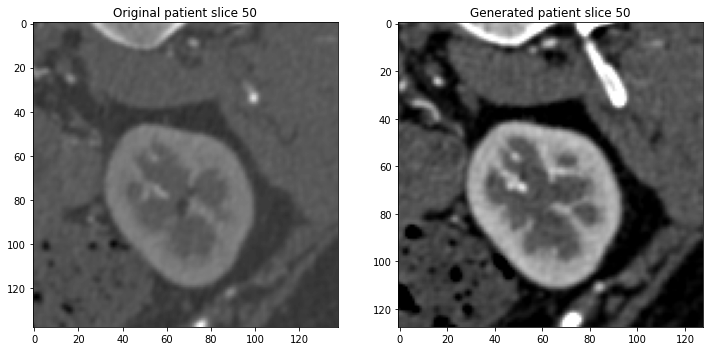

In [ ]:
import matplotlib.pyplot as plt
number_slice = 50
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")

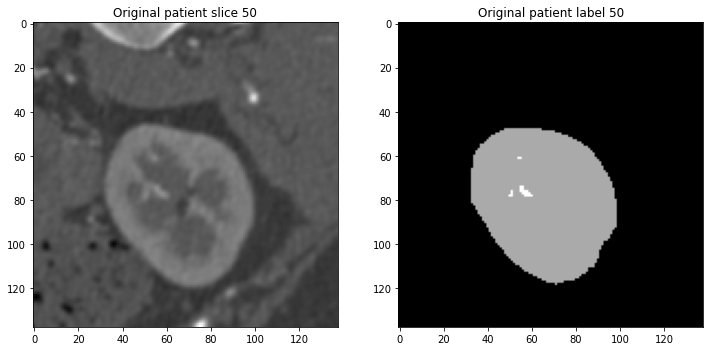

In [ ]:
import matplotlib.pyplot as plt
number_slice = 50
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Original patient label {number_slice}")
plt.imshow(original_patient["label"][0, 0, :, :, number_slice], cmap="gray")

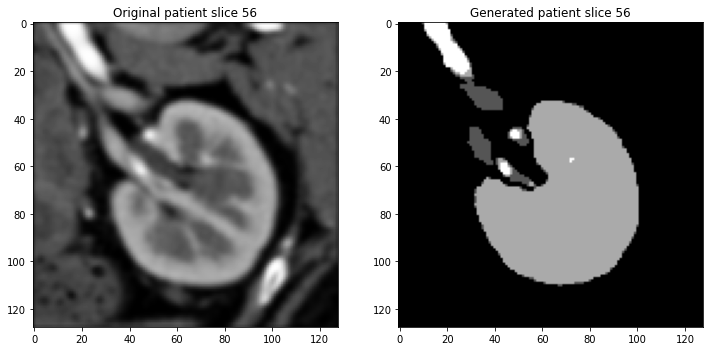

In [ ]:
import matplotlib.pyplot as plt
number_slice = 56
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["label"][0, 0, :, :, number_slice], cmap="gray")

In [ ]:
#image_keys: ["image"]
#all_keys: ["image", "label"]